In [1]:
import matplotlib.pylab as plt
# import networkx as nx
import numpy as np
import pandas as pd
import time
import sys
import os

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V

In [100]:
run_id = 1041

dts = DocTopic.objects.filter(run_id=run_id)

# total score of all DocTopics in run 1041 
dts.aggregate(
    n = Sum('score')
)

{'n': 5543152.99993363}

In [101]:
# total score of DocTopics, sorted by topic in run 1041, 
dts.values('topic').annotate(
    n = Sum('score')
)

<QuerySet [{'topic': 133127, 'n': 22641.227494564}, {'topic': 133120, 'n': 29252.1592249904}, {'topic': 133096, 'n': 155444.92247701}, {'topic': 133093, 'n': 61220.2016383137}, {'topic': 133082, 'n': 77088.6802376577}, {'topic': 133090, 'n': 196944.512938429}, {'topic': 133103, 'n': 58310.8435516128}, {'topic': 133118, 'n': 165253.103982201}, {'topic': 133092, 'n': 34531.1745385903}, {'topic': 133102, 'n': 47940.3988445615}, {'topic': 133080, 'n': 1924913.23646797}, {'topic': 133108, 'n': 230789.002299249}, {'topic': 133114, 'n': 41976.4846775167}, {'topic': 133122, 'n': 17267.9650383465}, {'topic': 133109, 'n': 86842.4401516253}, {'topic': 133121, 'n': 28037.1312809276}, {'topic': 133081, 'n': 55344.4964684282}, {'topic': 133097, 'n': 139678.596301962}, {'topic': 133085, 'n': 112512.661152613}, {'topic': 133100, 'n': 2870.92364985404}, '...(remaining elements truncated)...']>

In [183]:
# total DocTopic scores sorted by parliamentary period

#dts_toi = dts.filter(Q(topic__title__contains='umweltschutz') | Q(topic__title__contains='klimaschutz'))

dts_list = list(dts.values('ut__document__parlperiod__n').annotate(
    n = Sum('score')
))

df_dts_list = pd.DataFrame(dts_list)
#df_dts_list

In [182]:
# DocTopic scores for topic containing 'umweltschutz' and 'klimaschutz' in run 1041
# sorted by parliamentary period 

topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(n = Sum('score'))

pp_sum = dts.values('ut__document__parlperiod__n').annotate(n = Sum('score'))


df = pd.DataFrame.from_dict(list(topic_period_scores.filter(topic__title__contains='umweltschutz')))
    
df.columns = ['doctopic_score', 'topic', 'parlperiod']

df_pps = pd.DataFrame.from_dict(list(pp_sum))
df_pps.columns = ['pp_sum', 'parlperiod']

df = pd.concat([df, df_pps['pp_sum']], axis=1, join_axes=[df.index])

df['share'] = df['doctopic_score'] / df['pp_sum']

#df.to_csv('umweltschutz_klimaschutz_score.csv')

In [181]:
df2 = pd.DataFrame.from_dict(list(topic_period_scores.filter(topic__title__contains='klimaschutz')))
    
df2.columns = ['doctopic_score', 'topic', 'parlperiod']

df2 = pd.concat([df2, df_pps['pp_sum']], axis=1, join_axes=[df2.index])

df2['share'] = df2['doctopic_score'] / df2['pp_sum']

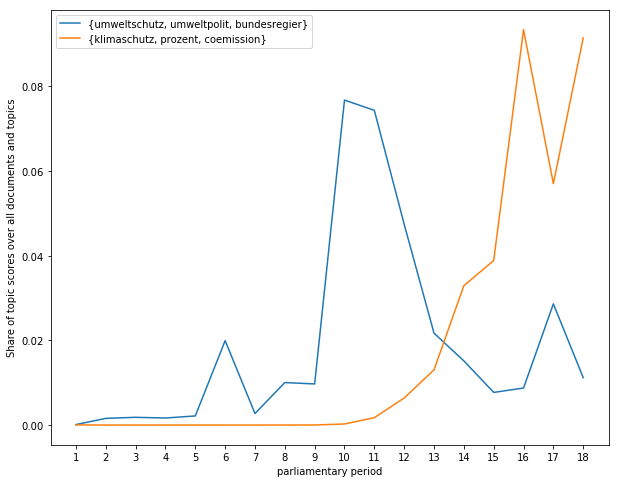

In [180]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df['parlperiod'],df['share'],label=df['topic'][0])
ax.plot(df2['parlperiod'],df2['share'],label=df2['topic'][0])

ax.set(xticks=range(1,19,1), xlabel='parliamentary period', ylabel='Share of topic scores over all documents and topics')
ax.legend()


fig.savefig('dtopicscore_share_comparison.png')